In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import NeuroLeap as nl

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

21th of October - 16:19 

Gathered 90 seconds of data, 
Individual finger movements, grouped finger movements (pairs) and all finger closing (grasping).

In [2]:
data = pd.read_csv("data/core_angles-core_hand-90s.csv")

In [3]:
data.head()

,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8,Thumb_TMC_fe,Thumb_tmc_aa,...,Index_pip,Middle_mcp_fe,Middle_mcp_aa,Middle_pip,Ring_mcp_fe,Ring_mcp_aa,Ring_pip,Little_mcp_fe,Little_mcp_aa,Little_pip
0,66,169,336,106,60,36,52,177,-0.426721,-0.357426,...,0.525832,-0.244179,0.032966,0.549186,-0.060919,0.056198,0.414670,0.129321,0.256497,0.276413
1,62,174,382,136,65,35,53,194,-0.366869,-0.388312,...,0.499922,-0.143054,0.061089,0.495434,0.006469,0.069382,0.420609,0.195207,0.256223,0.343590
2,66,155,355,148,67,36,59,213,-0.354629,-0.375564,...,0.460743,-0.143420,0.073726,0.456372,-0.014535,0.073582,0.410598,0.166725,0.247420,0.350135
3,66,147,349,150,69,35,51,185,-0.357055,-0.363991,...,0.446436,-0.166213,0.075594,0.441339,-0.038602,0.072703,0.412406,0.141356,0.245569,0.354557
4,64,124,322,142,57,30,45,147,-0.366679,-0.336791,...,0.454109,-0.211498,0.075711,0.450821,-0.075060,0.068880,0.434122,0.108157,0.239438,0.374375


<AxesSubplot:>

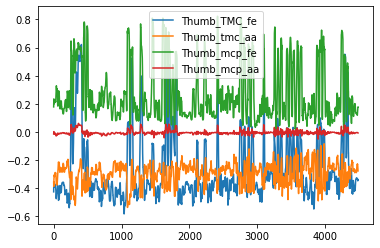

In [4]:
# Just considering the thumb
cols = ['Thumb_TMC_fe', 'Thumb_tmc_aa', 'Thumb_mcp_fe','Thumb_mcp_aa']
df = data[cols]
df.plot()

In [5]:
data.shape

(4486, 24)

## Plotting an example point. 

In [6]:
data.columns

Index(['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'Channel_5',
       'Channel_6', 'Channel_7', 'Channel_8', 'Thumb_TMC_fe', 'Thumb_tmc_aa',
       'Thumb_mcp_fe', 'Thumb_mcp_aa', 'Index_mcp_fe', 'Index_mcp_aa',
       'Index_pip', 'Middle_mcp_fe', 'Middle_mcp_aa', 'Middle_pip',
       'Ring_mcp_fe', 'Ring_mcp_aa', 'Ring_pip', 'Little_mcp_fe',
       'Little_mcp_aa', 'Little_pip'],
      dtype='object')

# Plotting the hand

C:\Users\ldavi\AppData\Local\Temp/ipykernel_37196/2484040394.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  joints_df = data.drop(channel_cols, 1)


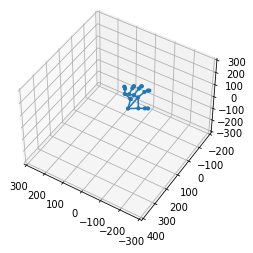

In [14]:
channel_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8']
joints_df = data.drop(channel_cols, 1)
examp_frame = joints_df.iloc[10].values

core_angles = examp_frame
angles = nl.get_all_bone_angles_from_core(core_angles)
points = nl.get_points_from_angles(angles)

# Five finger, 4 joints + palm, wrist. x,y,z
NUM_POINTS = (5 * 4 + 2) * 3

# Matplotlib Setup
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', xlim=(-300, 300), ylim=(-200, 400), zlim=(-300, 300))
ax.view_init(elev=45., azim=122)

patches = ax.scatter(points[0], points[1], points[2], s=10, alpha=1)
nl.plot_points(points, patches)
nl.plot_bone_lines(points, ax)

# Correlation matrix between EMG and Hand joints angle

[Text(0.5, 1.0, 'sEMG and Leap corrolations')]

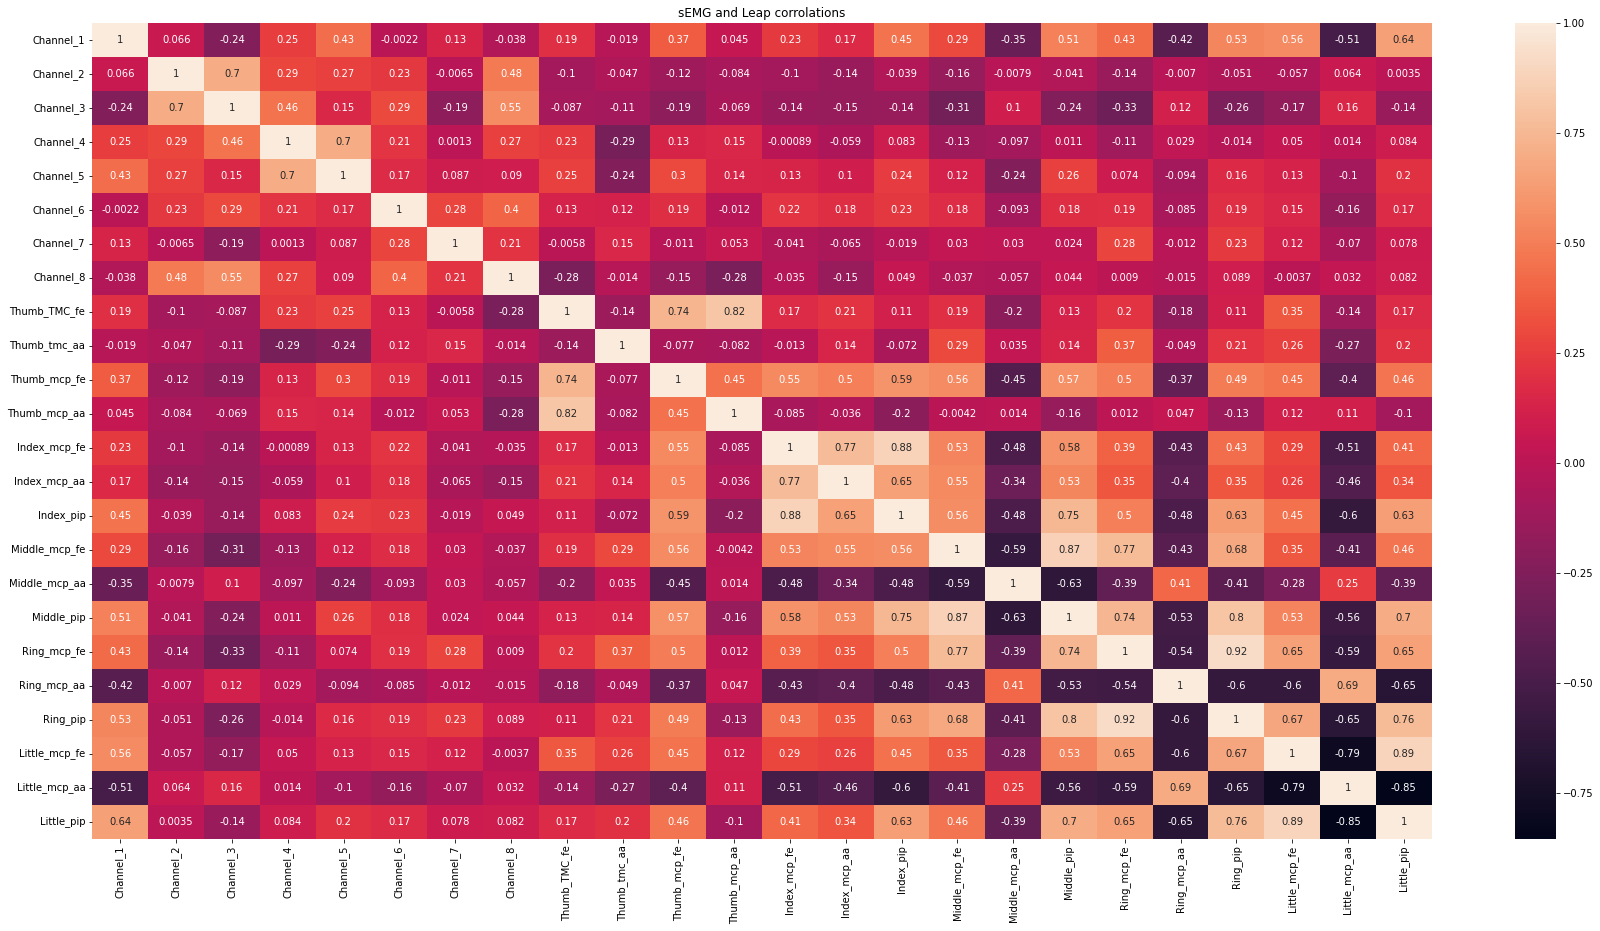

In [16]:
%matplotlib inline

plt.rc('figure', figsize=(30, 15))

sns.heatmap(data.corr(), annot=True).set(title="sEMG and Leap corrolations")

In [19]:
print("Correlation Matrix")
print()

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 10))

Correlation Matrix

Top Absolute Correlations
Thumb_TMC_fe  Thumb_mcp_aa    0.815146
              Thumb_mcp_fe    0.738625
Thumb_mcp_fe  Thumb_mcp_aa    0.448190
Thumb_TMC_fe  Thumb_tmc_aa    0.135404
Thumb_tmc_aa  Thumb_mcp_aa    0.081597
              Thumb_mcp_fe    0.076937
dtype: float64


# Learning

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

df = data
x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8']
X = df[x_cols]
y = df.drop(x_cols,1)

train_X, test_X, train_y, test_y = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.25)

# Making our benchmark model
# Just predict the mean average number of bikes. 
y_train_mean = train_y.mean()

train_preds = np.ones(train_y.shape) * y_train_mean
preds = np.ones(test_y.shape) * y_train_mean

rmse = np.sqrt(mean_squared_error(train_y, train_preds))
print("Train RMSE: %f" % (rmse))

mae = mean_absolute_error(train_y, train_preds)
print("Train MAE: %f" % (mae))

rmse = np.sqrt(mean_squared_error(test_y, preds))
print("Test RMSE: %f" % (rmse))

mae = mean_absolute_error(test_y, preds)
print("Test MAE: %f" % (mae))

r2_score(test_y, preds)

Train RMSE: 0.463947


C:\Users\ldavi\AppData\Local\Temp/ipykernel_37196/611646826.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  y = df.drop(x_cols,1)


Train MAE: 0.359281
Test RMSE: 0.465017
Test MAE: 0.359693


-23.703276904655358

# Making a baseline Neural Network

In [26]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'Channel_5',
       'Channel_6', 'Channel_7', 'Channel_8']

X = df[x_cols]
y = df.drop(x_cols,1)

rel_hand_scaler = StandardScaler()
emg_scaler = StandardScaler()

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25)
# Fit the scaler on the training set.
train_X = emg_scaler.fit_transform(train_X)
train_y = rel_hand_scaler.fit_transform(train_y)
# Scale the output data.
test_X = emg_scaler.transform(test_X)
test_y = rel_hand_scaler.transform(test_y)

model = Sequential()

# The Input Layer :
model.add(Dense(16,input_dim = train_X.shape[1], activation='relu'))

# The Hidden Layers :
model.add(Dense(32,activation='relu'))
model.add(Dense(64,activation='relu'))

# The Output Layer :
model.add(Dense(16,activation='linear'))

# Compile the network :
model.compile(loss='mse', optimizer='Adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                1040      
Total params: 3,840
Trainable params: 3,840
Non-trainable params: 0
_________________________________________________________________


C:\Users\ldavi\AppData\Local\Temp/ipykernel_37196/1160489111.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  y = df.drop(x_cols,1)


In [27]:
history = model.fit(train_X, train_y, epochs=200, batch_size=32, validation_data=(test_X, test_y))

Epoch 1/200
106/106 [==============================] - 1s 3ms/step - loss: 0.8739 - val_loss: 0.7345
Epoch 2/200
106/106 [==============================] - 0s 2ms/step - loss: 0.7033 - val_loss: 0.6763
Epoch 3/200
106/106 [==============================] - 0s 2ms/step - loss: 0.6500 - val_loss: 0.6458
Epoch 4/200
106/106 [==============================] - 0s 2ms/step - loss: 0.6215 - val_loss: 0.6253
Epoch 5/200
106/106 [==============================] - 0s 2ms/step - loss: 0.5966 - val_loss: 0.6113
Epoch 6/200
106/106 [==============================] - 0s 2ms/step - loss: 0.5777 - val_loss: 0.5929
Epoch 7/200
106/106 [==============================] - 0s 2ms/step - loss: 0.5628 - val_loss: 0.5835
Epoch 8/200
106/106 [==============================] - 0s 2ms/step - loss: 0.5487 - val_loss: 0.5704
Epoch 9/200
106/106 [==============================] - 0s 2ms/step - loss: 0.5373 - val_loss: 0.5601
Epoch 10/200
106/106 [==============================] - 0s 2ms/step - loss: 0.5264 - val_lo

In [28]:
# Evaluate the model on the test data
mse = model.evaluate(test_X, test_y)
mse

36/36 [==============================] - 0s 912us/step - loss: 0.4194


0.41944336891174316

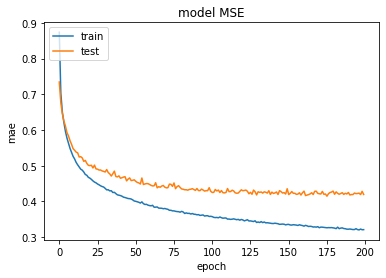

In [29]:
# summarize history for loss
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model MSE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
prediction = model.predict(train_X) # scaled inputs here
print(prediction)

# Scaling back the prediction
preds = rel_hand_scaler.inverse_transform(prediction)
# Scaling back the goals
goal = rel_hand_scaler.inverse_transform(train_y)

MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
print("MSE: ", MSE)
print("RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(goal, preds)
print("MAE: ", MAE)

[[ 0.6891082   0.918404    1.6446668  ...  1.0782905  -0.8170252
   1.1596111 ]
 [-0.23786019  0.3615185  -0.7573596  ... -1.3933951   1.0215034
  -1.1046755 ]
 [-0.1665954  -0.5534688   0.01430496 ... -0.11596381 -0.06067278
   0.235107  ]
 ...
 [-0.605104    0.270276   -0.5877104  ... -0.19019607  0.17040017
  -0.166728  ]
 [-0.60106933  0.161047   -0.5460041  ... -0.6334535   0.39068615
  -0.52224356]
 [-0.05513713  0.3858282   0.40006104 ...  2.2884097  -2.3353202
   2.3794491 ]]
MSE:  0.029981775502481278
RMSE:  0.17315246317185695
MAE:  0.10360554448142165


In [32]:
prediction = model.predict(test_X) # scaled inputs here
print(prediction)

# Scaling back the prediction
preds = rel_hand_scaler.inverse_transform(prediction)
# Scaling back the goals
goal = rel_hand_scaler.inverse_transform(test_y)

MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
print("MSE: ", MSE)
print("RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(goal, preds)
print("MAE: ", MAE)

[[-0.5011032   0.33033782 -0.8362295  ...  0.25737095  0.18409061
  -0.09632471]
 [-0.5435592   0.5008385  -0.4564492  ... -0.6866805   0.52008265
  -0.5964075 ]
 [-0.38826895  0.37389487 -0.97545844 ...  0.58492696  0.09922689
   0.01610736]
 ...
 [-0.5520809   0.5108516  -0.49087712 ...  0.25219536 -0.07667869
  -0.00316327]
 [-0.35610357 -0.2328868  -0.5970102  ... -0.414623    0.357441
  -0.4097831 ]
 [-0.67161614 -0.00749885 -0.53313327 ... -0.37507224  0.26438856
  -0.41591492]]
MSE:  0.040934615722033316
RMSE:  0.20232304792591801
MAE:  0.12113337338041238


In [35]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


# Plot the predicted vs ground truth

## Save the model and the scalers

In [37]:
import joblib

model_name = "NNRel-90secs-CORE-Hyro"

model.save(f"models/{model_name}.h5")
# Save hand scaler to file.
# Scales the output of the network, the relative position of the hand, min_max
joblib.dump(rel_hand_scaler, f'models/{model_name}-Hand.gz')

# Scales the input to the network, the emg data. 
joblib.dump(emg_scaler, f'models/{model_name}-EMG.gz')

['models/NNRel-90secs-CORE-Hyro-EMG.gz']

## Making a prediction

In [39]:
# Making a prediction in the prediction script.
from keras.models import load_model
model = load_model(f"models/{model_name}.h5")

input_scaler = joblib.load(f'models/{model_name}-EMG.gz')
output_scaler = joblib.load(f'models/{model_name}-Hand.gz')

# Get some input data
semg_input = np.array([[ 31, 140, 140,  83,  42,  30,  22,  21]])
# Scale the input
scaled_input = input_scaler.transform(semg_input)
# Get a prediction
pred = model.predict(scaled_input)
# Scale it back to a value
scaled_pred = output_scaler.inverse_transform(pred)
scaled_pred
# Five finger, 4 joints + palm, wrist. x,y,z
#NUM_POINTS = (5 * 4 + 2) * 3
#pred_points = scaled_pred.reshape((3, NUM_POINTS//3))

C:\Users\ldavi\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[-0.3357383 , -0.2614777 ,  0.21519472, -0.00633516, -0.21258667,
        -0.01934559,  0.55800843,  0.07339638,  0.10642937,  0.6494056 ,
         0.02509493,  0.08513846,  0.49624577, -0.01716971,  0.1895526 ,
         0.4420791 ]], dtype=float32)

## Plotting the prediction

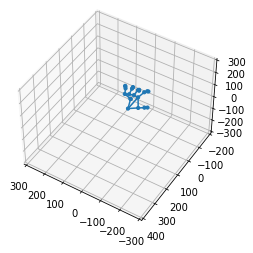

In [41]:
core_angles = scaled_pred[0]
angles = nl.get_all_bone_angles_from_core(core_angles)
points = nl.get_points_from_angles(angles)

# Five finger, 4 joints + palm, wrist. x,y,z
NUM_POINTS = (5 * 4 + 2) * 3

# Matplotlib Setup
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', xlim=(-300, 300), ylim=(-200, 400), zlim=(-300, 300))
ax.view_init(elev=45., azim=122)

patches = ax.scatter(points[0], points[1], points[2], s=10, alpha=1)
nl.plot_points(points, patches)
nl.plot_bone_lines(points, ax)

In [42]:
prediction = model.predict(test_X) # scaled inputs here
print(prediction)

# Scaling back the prediction
preds = rel_hand_scaler.inverse_transform(prediction)
# Scaling back the goals
goal = rel_hand_scaler.inverse_transform(test_y)

MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
print("MSE: ", MSE)
print("RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(goal, preds)
print("MAE: ", MAE)

[[-0.5011032   0.33033782 -0.8362295  ...  0.25737095  0.18409061
  -0.09632471]
 [-0.5435592   0.5008385  -0.4564492  ... -0.6866805   0.52008265
  -0.5964075 ]
 [-0.38826895  0.37389487 -0.97545844 ...  0.58492696  0.09922689
   0.01610736]
 ...
 [-0.5520809   0.5108516  -0.49087712 ...  0.25219536 -0.07667869
  -0.00316327]
 [-0.35610357 -0.2328868  -0.5970102  ... -0.414623    0.357441
  -0.4097831 ]
 [-0.67161614 -0.00749885 -0.53313327 ... -0.37507224  0.26438856
  -0.41591492]]
MSE:  0.040934615722033316
RMSE:  0.20232304792591801
MAE:  0.12113337338041238


## Calculating error per joints

In [52]:
#pred_points = preds
#goal_points = goal

#palm_preds = pred_points[:,:,0]
#palm_goals = goal_points[:,:,0]

#mse = mean_squared_error(preds[0], goal[0])
#mse

leaps = ['Thumb_TMC_fe','Thumb_tmc_aa','Thumb_mcp_fe','Thumb_mcp_aa','Index_mcp_fe','Index_mcp_aa','Index_pip','Middle_mcp_fe','Middle_mcp_aa','Middle_pip','Ring_mcp_fe','Ring_mcp_aa','Ring_pip','Little_mcp_fe','Little_mcp_aa','Little_pip']

errs = []
for i in range(len(leaps)):
    feat_preds = preds[i]
    feat_goals = goal[i]

    feat_mse = mean_squared_error(feat_goals, feat_preds)
    errs.append(feat_mse)
errs

[0.005459228261477859,
 0.03951474513597729,
 0.02807571419777142,
 0.007619378010788143,
 0.017718552437038897,
 0.05617286281755749,
 0.04795254596330338,
 0.04261122297077777,
 0.0289075660725403,
 0.1338209472933081,
 0.0038191536366085077,
 0.0063942690763334085,
 0.011320769981625584,
 0.05647348201213176,
 0.008148624813649067,
 0.13438269220241322]

<BarContainer object of 16 artists>

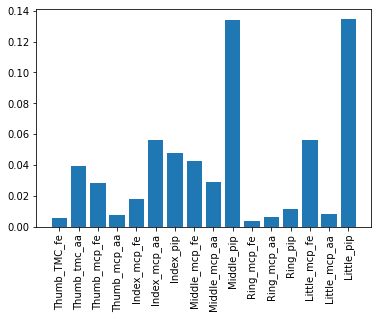

In [60]:
plt.xticks(rotation='vertical')
plt.bar(range(len(errs)),errs,tick_label=leaps)

Text(0, 0.5, 'RMSE (mm)')

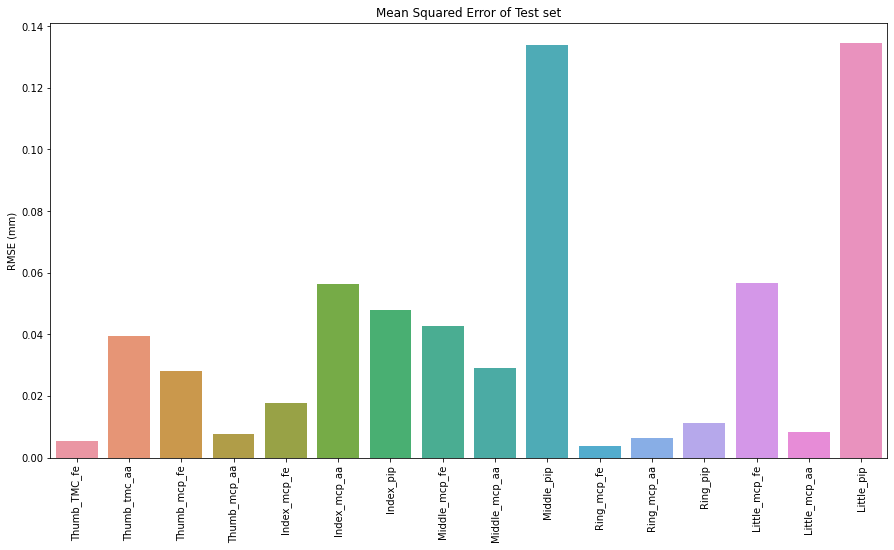

In [61]:
plt.figure(figsize=(15,8))
plt.xticks(rotation='vertical')
ax = sns.barplot(x=leaps,y=errs)
plt.title("Mean Squared Error of Test set")
plt.ylabel("RMSE (mm)")